# Table of contents
*  [Introduction](#section1)
*  [Read in the data](#section2)
*  [Feature engineering](#section3)
    - [Pandas date type](#section4)
    - [New indicators](#section5)
    - [NaN values](#section6)
*  [Train/Test split](#section7)
*  [Linear model](#section8)
*  [Random Forest](#section9)

by @samaxtech

---
<a id='section1'></a>
# Introduction
This project aims to predict the S&P500 Index using feature engineering,
creating new features based on the historical data, and building both a linear regression and Random Forest model.

In [37]:
!pip3 install pandas
!pip3 install numpy
!pip3 install datetime
!pip3 install scikit-learn
!pip3 install sklearn # LinearRegression
!pip3 install sklearn # mean_squared_error
!pip3 install sklearn # RandomForestRegresson
!pip3 install matplotlib
!pip3 install seaborn

  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your dependencies,
        it would be great if you take some time to track which package uses
        'sklearn' instead of 'scikit-learn' and report it to their issue tracker
      - as a last resort, set the environment variable
        SKLEARN_ALLOW_DEPRECATED_SKLEARN_PACKAGE_INSTALL=True to avoid this error
      
    

In [38]:
import pandas as pd
import numpy as np
from datetime import datetime

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

<a id='section2'></a>
# Read in the data

The dataset contains historical data on the price of the S&P500 Index. The columns are:

- Date: The date of the record.
- Open: The opening price of the day (when trading starts).
- High: The highest trade price during the day.
- Low: The lowest trade price during the day.
- Close: The closing price for the day (when trading is finished).
- Volume: The number of shares traded.
- Adj Close: The daily closing price, adjusted retroactively to include any corporate actions.

In [39]:
# had a bug in the string of file sphist didn't need "~/Users/owner/pbox/mstables/mstables"
sphist = pd.read_csv('data/sphist.csv')
print(sphist.describe())
print("\ndf shape: ", sphist.shape)
# sphist.head()
sphist

               Open          High           Low         Close        Volume  \
count  16590.000000  16590.000000  16590.000000  16590.000000  1.659000e+04   
mean     482.570941    485.624237    479.367501    482.692491  7.940099e+08   
std      554.889186    558.186049    551.367625    555.007904  1.456582e+09   
min       16.660000     16.660000     16.660000     16.660000  6.800000e+05   
25%       83.860001     84.594997     83.139997     83.860001  7.610000e+06   
50%      144.049996    145.294998    143.105004    144.264999  7.170500e+07   
75%      950.722488    956.665024    941.969986    950.797500  7.866750e+08   
max     2130.360107   2134.719971   2126.060059   2130.820068  1.145623e+10   

          Adj Close  
count  16590.000000  
mean     482.692491  
std      555.007904  
min       16.660000  
25%       83.860001  
50%      144.264999  
75%      950.797500  
max     2130.820068  

df shape:  (16590, 7)


,Date,Open,High,Low,Close,Volume,Adj Close
0,2015-12-07,2090.419922,2090.419922,2066.780029,2077.070068,4.043820e+09,2077.070068
1,2015-12-04,2051.239990,2093.840088,2051.239990,2091.689941,4.214910e+09,2091.689941
2,2015-12-03,2080.709961,2085.000000,2042.349976,2049.620117,4.306490e+09,2049.620117
3,2015-12-02,2101.709961,2104.270020,2077.110107,2079.510010,3.950640e+09,2079.510010
4,2015-12-01,2082.929932,2103.370117,2082.929932,2102.629883,3.712120e+09,2102.629883
...,...,...,...,...,...,...,...
16585,1950-01-09,17.080000,17.080000,17.080000,17.080000,2.520000e+06,17.080000
16586,1950-01-06,16.980000,16.980000,16.980000,16.980000,2.010000e+06,16.980000
16587,1950-01-05,16.930000,16.930000,16.930000,16.930000,2.550000e+06,16.930000
16588,1950-01-04,16.850000,16.850000,16.850000,16.850000,1.890000e+06,16.850000


In [40]:
# Import required libraries
import pandas as pd
import sqlite3
from datetime import datetime

def get_stock_data(ticker):
    """
    Get historical price data for a given ticker from the database.

    Args:
        ticker (str): Stock ticker symbol

    Returns:
        pandas.DataFrame: DataFrame containing stock data
    """
    # Connect to the database
    conn = sqlite3.connect('data/mstables.sqlite')

    # First, get the ticker_id from the Tickers table
    ticker_query = f"SELECT id FROM Tickers WHERE ticker = '{ticker}'"
    ticker_id = pd.read_sql_query(ticker_query, conn)

    if ticker_id.empty:
        conn.close()
        raise ValueError(f"Ticker {ticker} not found in database")

    ticker_id = ticker_id.iloc[0]['id']

    # Try different tables for price data
    tables_to_try = [
        ('tiingo_prices', 'date', 'open', 'high', 'low', 'close', 'volume'),
        ('YahooQuote', 'date', 'open', 'high', 'low', 'close', 'volume')
    ]

    df = None
    for table, date_col, open_col, high_col, low_col, close_col, vol_col in tables_to_try:
        try:
            query = f'''
                SELECT {date_col} as Date,
                       {open_col} as Open,
                       {high_col} as High,
                       {low_col} as Low,
                       {close_col} as Close,
                       {vol_col} as Volume
                FROM {table}
                WHERE symbol = '{ticker}'
                ORDER BY {date_col}
            '''
            df = pd.read_sql_query(query, conn)
            if not df.empty:
                print(f"Found data for {ticker} in {table}")
                break
        except Exception as e:
            print(f"No data in {table} for {ticker}: {str(e)}")
            continue

    # If no data found in other tables, try MSpricehistory
    if df is None or df.empty:
        try:
            query = f'''
                SELECT
                    m.last_open as Open,
                    m.last_open as High,  -- Using last_open as approximation
                    m.last_open as Low,   -- Using last_open as approximation
                    m.last_close as Close,
                    NULL as Volume,       -- Volume not available in MSpricehistory
                    (SELECT date FROM TimeRefs WHERE id = m.max_var5_date) as Date
                FROM MSpricehistory m
                WHERE m.ticker_id = {ticker_id}
            '''
            df = pd.read_sql_query(query, conn)
            if not df.empty:
                print(f"Found data for {ticker} in MSpricehistory")
        except Exception as e:
            print(f"No data in MSpricehistory for {ticker}: {str(e)}")

    conn.close()

    if df is None or df.empty:
        raise ValueError(f"No data found for ticker {ticker}")

    # Convert Date column to datetime
    df['Date'] = pd.to_datetime(df['Date'])

    return df

# Get data for a specific ticker
ticker = 'AAPL'  # Replace with your desired ticker
sphist = get_stock_data(ticker)

# Display basic statistics
print(sphist.describe())
print("\ndf shape: ", sphist.shape)
sphist

Found data for AAPL in tiingo_prices
             Open        High         Low       Close        Volume
count   13.000000   13.000000   13.000000   13.000000  1.300000e+01
mean   205.955385  207.688292  203.204208  205.836923  5.731383e+07
std      5.752108    5.964841    6.361003    6.829661  1.609958e+07
min    197.720000  199.440000  193.250000  196.250000  3.645392e+07
25%    199.170000  200.650000  197.535000  198.530000  4.932582e+07
50%    207.910000  209.480000  204.260000  208.780000  5.190933e+07
75%    210.950000  212.960000  209.000000  211.450000  6.377581e+07
max    212.430000  214.560000  210.580100  213.320000  1.010106e+08

df shape:  (13, 6)


,Date,Open,High,Low,Close,Volume
0,2025-05-01 00:00:00+00:00,209.08,214.5600,208.9000,213.32,57365675
1,2025-05-02 00:00:00+00:00,206.09,206.9900,202.1600,205.35,101010621
2,2025-05-05 00:00:00+00:00,203.10,204.1000,198.2100,198.89,69018452
3,2025-05-06 00:00:00+00:00,198.21,200.6500,197.0200,198.51,51216482
4,2025-05-07 00:00:00+00:00,199.17,199.4400,193.2500,196.25,68616943
5,2025-05-08 00:00:00+00:00,197.72,200.0500,194.6796,197.49,50478872
6,2025-05-09 00:00:00+00:00,199.00,200.5399,197.5350,198.53,36453923
7,2025-05-12 00:00:00+00:00,210.97,211.2679,206.7500,210.79,63775814
8,2025-05-13 00:00:00+00:00,210.43,213.4000,209.0000,212.93,51909332
9,2025-05-14 00:00:00+00:00,212.43,213.9400,210.5801,212.33,49325825


<a id='section3'></a>
# Feature engineering
<a id='section4'></a>
## Pandas date type

In [41]:
# Convert 'Date' column to Pandas date type
sphist['Date'] = pd.to_datetime(sphist['Date'])

# Sort df by that column
sphist.sort_values(by=['Date'], inplace=True)
#sphist()

<a id='section5'></a>
## New indicators

Given the nature of the stock market, in order to prevent injecting future knowledge into the model,
let's create indicators based on the past.

- 1) Average price for the last 5 days
- 2) Average price for the last 365 days
- 3) Ratio between the average price for the past 5 days, and the average price for the past 365 days.
- 4) Standard deviation of the price for the last 5 days
- 5) Standard deviation of the price for the last 365 days
- 6) Ratio between the standard deviation for the past 5 days, and the standard deviation for the past 365 days.
- 7) The average volume over the past five days.
- 8) The average volume over the past year.
- 9) The ratio between the average volume for the past five days, and the average volume for the past year.
- 10) The ratio between the lowest price in the past year and the current price.

In [42]:
# Add new indicators to each observation:
# 1
sphist['avg_price_5'] = sphist['Close'].rolling(5).mean()
sphist['avg_price_5'] = sphist['avg_price_5'].shift() # Avoid using current day's price by reindexing

# 2
sphist['avg_price_365'] = sphist['Close'].rolling(365).mean()
sphist['avg_price_365'] = sphist['avg_price_365'].shift() # Avoid using current day's price by reindexing

# 3
sphist['avg_price_5_365'] = sphist['avg_price_5'] / sphist['avg_price_365']

# 4
sphist['std_price_5'] = sphist['Close'].rolling(5).std()
sphist['std_price_5'] = sphist['std_price_5'].shift() # Avoid using current day's price by reindexing

# 5
sphist['std_price_365'] = sphist['Close'].rolling(365).std()
sphist['std_price_365'] = sphist['std_price_365'].shift() # Avoid using current day's price by reindexing

# 6
sphist['std_price_5_365'] = sphist['std_price_5'] / sphist['std_price_365']

# 7
sphist['avg_volume_5'] = sphist['Volume'].rolling(5).mean()
sphist['avg_volume_5'] = sphist['avg_volume_5'].shift() # Avoid using current day's price by reindexing

# 8
sphist['avg_volume_365'] = sphist['Volume'].rolling(365).mean()
sphist['avg_volume_365'] = sphist['avg_volume_365'].shift() # Avoid using current day's price by reindexing

# 9
sphist['avg_volume_5_365'] = sphist['avg_volume_5'] / sphist['avg_volume_365']

# 10
min_last_year = sphist['Close'].rolling(365).min()
sphist['last_min_current_ratio'] = min_last_year / sphist['Close']
sphist['last_min_current_ratio'] = sphist['last_min_current_ratio'].shift()

<a id='section6'></a>
## NaN values
Since the new indicators require data from the previous 5 and 365 days,
after adding them, considering the first observation corresponds to 1950-01-03, we need to:

- Remove any rows from the DataFrame that fall before 1951-01-03
- Remove any rows with NaN values

In [43]:
print("# of observations before: ", sphist.shape[0])
print("NaN values before: \n\n", sphist.isnull().sum())

sphist = sphist[sphist['Date'] > datetime(year=1951, month=1, day=2)]
sphist.dropna(axis=0, inplace=True)

print("\n# of observations after: ", sphist.shape[0])
print("NaN values after: \n\n", sphist.isnull().sum())

# of observations before:  13
NaN values before: 

 Date                       0
Open                       0
High                       0
Low                        0
Close                      0
Volume                     0
avg_price_5                5
avg_price_365             13
avg_price_5_365           13
std_price_5                5
std_price_365             13
std_price_5_365           13
avg_volume_5               5
avg_volume_365            13
avg_volume_5_365          13
last_min_current_ratio    13
dtype: int64


TypeError: Invalid comparison between dtype=datetime64[ns, UTC] and datetime

<a id='section7'></a>
# Train/Test split

- Training set: Observations up to 2013-01-01
- Test set: Observations after 2013-01-01

In [31]:
train = sphist[sphist["Date"] < datetime(year=2010, month=1, day=1)]
test = sphist[sphist["Date"] >= datetime(year=2010, month=1, day=1)]

print("Train: ", train.shape)
print("Test: ", test.shape)

Train:  (14732, 17)
Test:  (1493, 17)


<a id='section8'></a>
# Linear model

last_min_current_ratio   -0.105400
avg_volume_5_365         -0.012305
avg_price_5_365           0.047782
std_price_5_365           0.087018
std_price_5               0.722414
Volume                    0.772817
avg_volume_5              0.780896
avg_volume_365            0.784878
std_price_365             0.816103
Date                      0.872202
avg_price_365             0.988870
avg_price_5               0.999793
Open                      0.999900
High                      0.999953
Low                       0.999956
Adj Close                 1.000000
Close                     1.000000
Name: Close, dtype: float64


<Axes: >

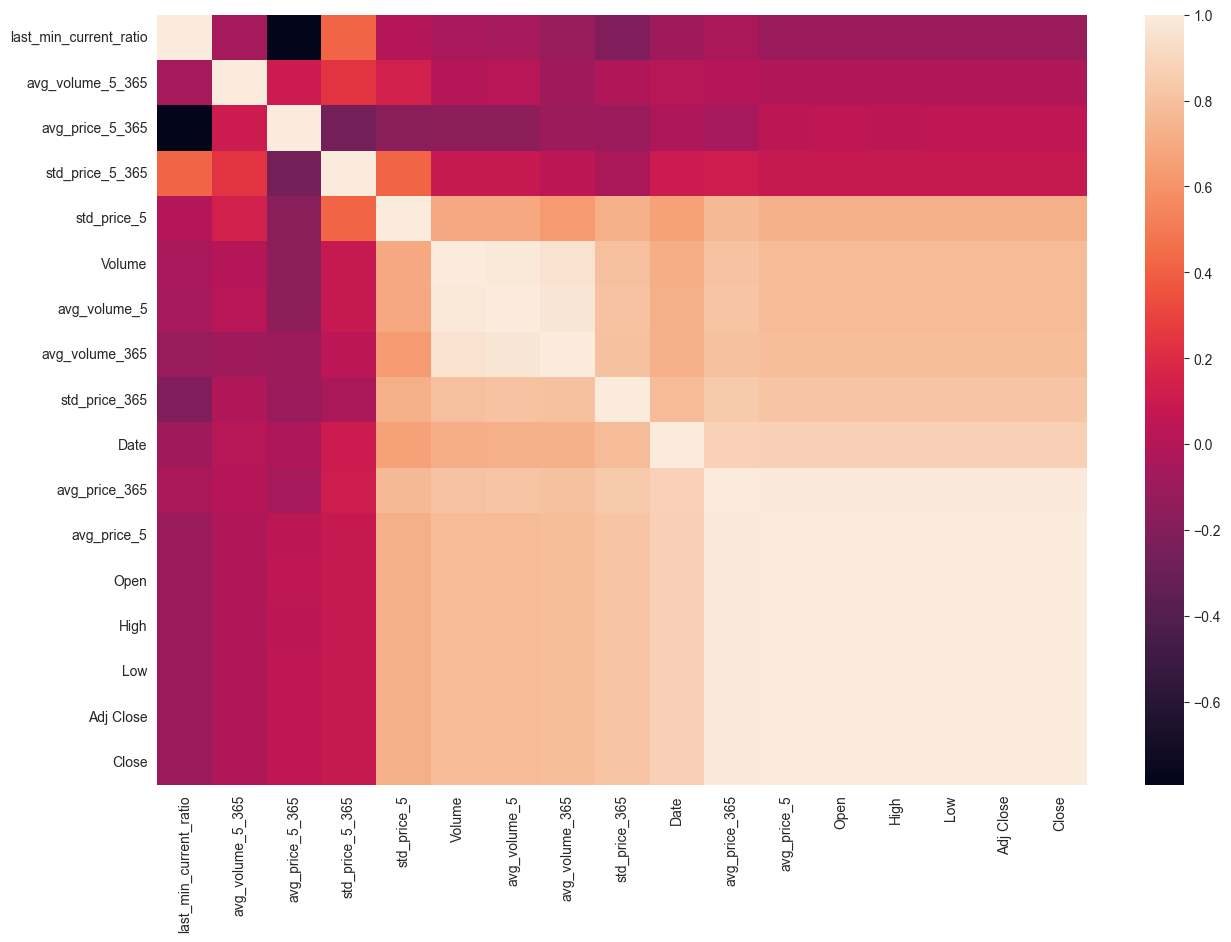

In [32]:
# Sorted correlations with target column 'Close'
sorted_corrs = sphist.corr()['Close'].sort_values()

print(sorted_corrs)
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(sphist[sorted_corrs.index].corr())

In [33]:
features = ['avg_price_5', 'avg_price_365', 'avg_price_5_365', 'std_price_5',
            'std_price_365', 'std_price_5_365', 'avg_volume_5', 'avg_volume_365',
            'avg_volume_5_365', 'last_min_current_ratio']

X_train = train[features]
y_train = train['Close']

X_test = test[features]
y_test = test['Close']

# Train
lr = LinearRegression()
lr.fit(X_train, y_train)

# Predict
closing_price_pred_lr = lr.predict(X_test)

# --------------------------------------------------
# Performance metrics
# --------------------------------------------------

# Calculate MSE
mse_lr = mean_squared_error(y_test, closing_price_pred_lr)

# Calculate the absolute errors and MAPE
errors_lr = abs(closing_price_pred_lr - y_test)
mape_lr = 100 * (errors_lr / y_test)

# MAE
mae_lr = round(np.mean(errors_lr), 2)

# Accuracy
accuracy_lr = 100 - np.mean(mape_lr)

print("-----------------\nLinear regression\n-----------------")
print("MSE: ", mse_lr)
print("MAE: ", mae_lr, "degrees")
print('Accuracy:', round(accuracy_lr, 2), '%.')

-----------------
Linear regression
-----------------
MSE:  439.81263560996274
MAE:  15.59 degrees
Accuracy: 98.96 %.


<a id='section9'></a>
# Random Forest

In [34]:
rf = RandomForestRegressor(n_estimators=150, random_state=1, min_samples_leaf=2)

# Train
rf.fit(X_train, y_train)

# Predict
closing_price_pred_rf = rf.predict(X_test)

# --------------------------------------------------
# Performance metrics
# --------------------------------------------------

# Calculate the absolute errors and MAPE
errors_rf = abs(closing_price_pred_rf - y_test)
mape_rf = 100 * (errors_rf / y_test)

# MAE
mae_rf = round(np.mean(errors_rf), 2)

# Accuracy
accuracy_rf = 100 - np.mean(mape_rf)

print("-----------------\nRandom Forest\n-----------------")
print("MAE: ", mae_rf, "degrees")
print('Accuracy:', round(accuracy_rf, 2), '%.')

-----------------
Random Forest
-----------------
MAE:  179.85 degrees
Accuracy: 90.63 %.
